# Цель
Необходимо создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. Для оценки использовать метрику MAPE (Mean Absolute Percentage Error)
# Задачи
1. Используем датасет собранный с сайта auto.ru и предложенный в рамках задания (parsing_all_moscow_auto_ru_09_09_2020). 
2. Также для единой обработке и создания новых колонок необходимо объединить 2 учебных датасета и 1 тестовый датасет.
   Для этого необходимо обследовать три датасета на предмет расхождений:
   - отсутствие колонок - (удалить либо создать);
   - присутствие схожих по значению колонок, но с разными наименованиями - (переименовать);
   - присутствие одинаковых колонок, но разного типа - (привести к одному типу);
   - скорректировать цену автомобилей в новом датасете на размер инфляции за 1 год 4 месяца
3. обработать дублирование (удалить), пропуски (заполнить или удалить), выбросы (заменить или удалить)
4. Выделить типы колонок (бинарный, категориальный, ординарный и числовой)
5. Добавить новые колонки (Feature Engineering)

In [786]:
# загрузка необходимых библиотек
import pandas as pd
import sys
import numpy as np
import itertools
import datetime
import re
from datetime import datetime
import pandas_profiling
from pandas import Series
from scipy.stats import ttest_ind
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from itertools import combinations
from catboost import CatBoostRegressor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [787]:
#показывать dataframe без ограничения количества столбцов и 100 строк по умолчанию
pd.options.display.max_rows = 2
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', 100)

In [788]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.1


# Functions

In [789]:
# функция сравнения колонок датасета и типа колонок
# Функция вызывается при анализе перед соединение 3 баз
def print_df_differences(
    dfs_names: list, 
    dfs: list
):    
    for df in itertools.permutations(zip(dfs_names, dfs)):
        print(f"\nКолонки есть в датасет -{df[0][0]}, но нет в датасет -{df[1][0]}:")
        print(set(df[0][1].columns).difference(df[1][1].columns))
        for col in set(df[0][1].columns).intersection(df[1][1].columns):
            if df[0][1][col].dtypes != df[1][1][col].dtypes:
                print(f"Общая колонка {col}: {df[0][1][col].dtypes} в -{df[0][0]} датасет и {df[1][1][col].dtypes} в -{df[1][0]} датасет")
                
# ----------------------
# Функция достает из поля Name данные о объеме двигателя
# Функция вызывается при анализе поля "engineDisplacement"

def full_eD(name, eD):
    pattern = re.compile('\d\.\d+')
    try:
        return float(pattern.findall(eD)[0]) 
    except (IndexError, TypeError):
        try:
            return float(pattern.findall(name)[0])
        except (IndexError, TypeError):
            return 0
#----------------------------
# Функция печатает общую информацию при анализе полей
# Вызывается для каждого поля
def print_common_inf(name_col):
    print('Пропуски:', cdf[name_col].isna().sum())
    print('Количество значений:', cdf[name_col].nunique())
    print('Список значений:', cdf[name_col].unique())
    print('Тип колонки:', cdf[name_col].dtypes)
        
#----------------------------------
#Функция преобразовывает тип двигателя на 2 поля: тип двинателя и есть/нет газовое оборудование
# Функция вызывается при анализе поля "fuelType"
def full_fT(fuelType):
    if (not fuelType is None) and (fuelType != 'nan')and (isinstance(fuelType, str)): 
        fuelType = fuelType.lower()
        fT1 = (fuelType.split(',')[0]).strip(' ')
        try:
            if (fuelType.split(',')[1]).strip(' '):
                fT2 = 1
        except:
            fT2 = 0
    else:
        fT1 = str('unknown')
        fT2 = 0
    return fT1, fT2

#-----------------------------------
# Функция заполняет недостояющие данные из аналогичных моделей в базе (например дата модели, количество дверей)
# вызывается при анализе поля dateModel
def full_MD(name, brand, bodyType, model_name, engineDisplacement, enginePower, fuelType): # имя заполняемого поля и значение
    try:
        r = cdf[name][(cdf.brand == brand)&(cdf.bodyType == bodyType)& (cdf.model_name == model_name)&
                         (cdf.engineDisplacement == engineDisplacement)&(cdf.enginePower == enginePower)&\
                         (cdf.fuelType == fuelType)&(cdf.modelDate != 0)].values[0]
        return float(r)
    except:
        return int(0)
    
#-----------------------------------
# Функции прогнозирования цены по CatBoost для подбора коэф-а инфляция
# Для этого учиться на новой скаченной и тестириуется на train с каггла, которая скачено в одно время с 
# с базой для предсказания ('../input/parsing-all-moscow-auto-ru-09-09-2020/').
# Вызывается при анализе поля price
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def CatBoostPredict(X_train_inf, Y_train_inf, X_test_inf, Y_test_inf):
    catb_def = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
    catb_def.fit(X_train_inf, Y_train_inf,
         #cat_features= cat_features_ids,
         eval_set=(X_test_inf, Y_test_inf),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )
    predict_test = catb_def.predict(X_test_inf)
    result = round((mape(Y_test_inf, predict_test))*100,2)
    print(f"Точность модели по метрике MAPE: {result}%")

# Setup

In [790]:
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # датасет из задания
DIR_TRAIN_PARSED  = '../input/final-car-price-prediction-df-parsed-sep-2021/' # собранный датасет с `auto.ru`
DIR_TEST   = '../input/sf-dst-car-price-prediction/' # тестовый датасет
VAL_SIZE   = 0.20   # 20%

In [791]:
# загружаем датасеты, предложенные в рамках задания
# train = pd.read_csv(DIR_TRAIN + 'all_auto_ru_09_09_2020.csv') 
# test = pd.read_csv(DIR_TEST + 'test.csv')
# sample_submission = pd.read_csv(DIR_TEST + 'sample_submission.csv')

DIR_TRAIN = DIR_TEST = './data/'
train = pd.read_csv(DIR_TRAIN + 'all_auto_ru_09_09_2020.csv') 

test = pd.read_csv(DIR_TEST + 'test.csv')

# загружаем датасеты, скаченные дополнительно
train_parsed = pd.DataFrame()
for i in range(1, 15):
    path_str = './data/12 брендов по все россии/сами данные/' + str(i) + '_cars.csv'
    cars_part = pd.read_csv(path_str, sep=';', )
    train_parsed = train_parsed.append(cars_part, ignore_index = True)  
    
print(f'train:{len(train)}, test: {len(test)}, train_parsed: {len(train_parsed)}')

# train:89378, test: 34686, train_parsed: 87978

train:89378, test: 34686, train_parsed: 87978


In [792]:
# в процессе закачки с сайта появились пустые строки и возможно дублирование, удалим их
print('До удаления: ', len(train_parsed))
train_parsed.dropna(how = 'all', axis = 0, inplace=True)
train_parsed = train_parsed.drop_duplicates(subset=['sell_id'], keep = 'last')
print('После удаления: ', len(train_parsed))
#До удаления:  87599
#После удаления:  85608

До удаления:  87978
После удаления:  85608


In [793]:
# удалим дубликаты в датасет из задания (train)
print('До удаления: ', len(train))
train.dropna(how = 'all', axis = 0, inplace=True) # полностью пустых строк не было
train = train.drop_duplicates(keep = 'first') #зато дублированных побольше 2 114
print('После удаления: ', len(train))
#До удаления:  89378
#После удаления:  87264

До удаления:  89378
После удаления:  87264


In [794]:
# скопируем, что всегда иметь доступ к первоисточнику
train_ = train.copy()
test_ = test.copy()
train_parsed_ = train_parsed.copy()

Тестовая база содержит следующие поля:
---  ------                --------------  ----- 
 0   bodyType               - тип кузова автомобиля,
 1   brand                  - производитель
 2   car_url                - ссылка на объявление
 3   color                  - цвет
 4   complectation_dict     - дополнительная информация об автомобиле (справочник)
 5   description            - описание от продавца
 6   engineDisplacement     - объем двигателя
 7   enginePower            - мощность двигателя
 8   equipment_dict         - компликтация (справочник)
 9   fuelType               - тип топлива
 10  image                  - ссылка на фото
 11  mileage                - пробег 
 12  modelDate              - дата выпуска модели 
 13  model_info             - описание модели (справочник)
 14  model_name             - имя модели 
 15  name                   - объем двигателя + мощность двигателя
 16  numberOfDoors          - число дверей
 17  parsing_unixtime       - время парсинга
 18  priceCurrency          - валюта
 19  productionDate         - дата выпуска машины
 20  sell_id                - идентификатор продавца
 21  super_gen              -  
 22  vehicleConfiguration   - 
 23  vehicleTransmission    - тип коробки передач (механическая, автоматическая, вариатор, роботизированная)
 24  vendor                 - страна производитель
 25  Владельцы              - число владельцев авто (1, 2, 3 и более)
 26  Владение               - время использования текущим владельцем
 27  ПТС                    - оригинальность ПТС (Оригинал, Дубликат)
 28  Привод                 - тип привода (передний, полный, задний)
 29  Руль                   - размещение рулевого колеса (Левый, Правый)
 30  Состояние              - необходимость ремонта (Не требует ремонта, Битый / не на ходу)
 31  Таможня               -  необходимость процедуры растаможивания

# Объединение 3 баз (2 учебных датасета и 1 тестовый датасет)

In [795]:
print_df_differences(dfs_names=['train', 'train_parsed', 'test'], dfs=[train_, train_parsed_, test_])


Колонки есть в датасет -train, но нет в датасет -train_parsed:
{'start_date', 'hidden', 'Владение', 'Комплектация', 'vehicleConfiguration', 'modelDate', 'model'}
Общая колонка numberOfDoors: float64 в -train датасет и object в -train_parsed датасет
Общая колонка productionDate: int64 в -train датасет и float64 в -train_parsed датасет
Общая колонка price: float64 в -train датасет и object в -train_parsed датасет
Общая колонка Состояние: float64 в -train датасет и object в -train_parsed датасет
Общая колонка Таможня: bool в -train датасет и object в -train_parsed датасет
Общая колонка Владельцы: float64 в -train датасет и object в -train_parsed датасет
Общая колонка enginePower: float64 в -train датасет и object в -train_parsed датасет
Общая колонка mileage: int64 в -train датасет и object в -train_parsed датасет

Колонки есть в датасет -train, но нет в датасет -test:
{'start_date', 'hidden', 'Комплектация', 'price', 'model'}
Общая колонка numberOfDoors: float64 в -train датасет и int64

### датасет -train
1. Колонка 'Комплектация' (словарь данных по комплектации): аналог 'complectation_dict' в базе тест, нет в train_parsed. Подлежит удалению
2. Колонка 'start_date'(показывает дату объявления): - полезно, но нет в test. Подлежит удалению.
3. Колонка 'model' (модель): аналог model_name, переименовать
4. Колонка 'Владение' (продолжительность владения текущим продавцом): аналог 'Владение' в базе тест, нет в train_parsed. Подлежит удалению
5. Колонка 'modelDate' - аналог 'modelDate' в базе тест, нет в train_parsed. Подлежит удалению
6. Колонка 'hidden' - пустая колонка. Подлежит удалению
7. Колонка 'vehicleConfiguration': содержит 'bodyType' + 'vehicleTransmission'+ 'engineDisplacement'. Подлежит удалению
8. Cоздадим новую колонку "parsing_date" = 09/09/2020

In [796]:
# датасет -train # команды для анализа
#set(train_['vehicleConfiguration'].values) # множество уникальных значений
#train_.hidden.isnull().sum()/len(train_.hidden)*100 #доля пустых знаыений в колонке

In [797]:
# удаляем столбцы, которые решили убрать
train_.drop(columns = ['Комплектация','start_date','Владение','hidden','vehicleConfiguration'],\
           inplace = True, axis = 1)

In [798]:
# переименование столбцов
train_.rename(columns = {'model':'model_name'}, inplace=True)

In [799]:
# создание колонки "parsing_date" = 09/09/2020
train_['parsing_date'] = datetime.strptime('09/09/2020', '%d/%m/%Y')

### датасет -train_parsed
1. Колонка'sell_id': 94% уникальных значений. Подлежит удалению
2. Колонка 'model_name2': отсутствует в базе -train и -test. Подлежит удалению
3. Колонка 'card_type': содержит только значения {nan, 'Б/у'}, так как база изначально поддержанных авто, подлежит удалению
4. Колонка 'parsing_unixtime': создадим на ее основе новую колонку "parsing_date", а 'parsing_unixtime' удалим 
5. Колонка 'car_url': нет в датасет train, придется удалить 
6. Колонка 'model_name': в датасет -train перименовали ранее
7. Колонка 'datetime': убираем, оставляем новую колонку 'parsing_date'
8. Колонка 'confDict' (словарь описания модели): создадим на его основе новую колонку 'modelDate' (есть в train, test)
9. Колонка 'image' (ссылка): нет в train, придется удалить
10. Колонка 'dateAdvertisement' (дата выхода объявления): нет в test, придется удалить;
11. Колонка 'engine': 'engineDisplacement'+'enginePower'+'fuelType', подлежит удалению
12. Колонка 'model_name_full': 'brand'+'model_name'+'model_name2', подлежит удалению

In [800]:
# датасет -train команды для анализа
#set(train_parsed_['card_type'].values) # множество уникальных значений
# len(train_parsed_['sell_id'].value_counts())/len(train_parsed['sell_id'])*100
#train_parsed_.hidden.isnull().sum()/len(train_parsed_.hidden)*100 #доля пустых значений в колонке

In [801]:
# на основе колонки parsing_unixtime создаем колонку parsing_date
train_parsed_['parsing_date'] = pd.to_datetime(train_parsed_['parsing_unixtime'], unit='s') #преобразует в тип datetime64
train_parsed_['parsing_date'] = pd.to_datetime(train_parsed_['parsing_date'].dt.floor('d')) #округляет до дня 

In [802]:
# вытащим из словаря confDict год модели, если нет - ставим 0
pattern = re.compile("'year': \d+")
train_parsed_['modelDate'] = train_parsed_['confDict'].apply(lambda x: int(0) if pd.isna(x) else int(pattern.findall(x)[0][8:]))

In [803]:
# удаляем столбцы, которые решили убрать
train_parsed_.drop(['sell_id','model_name2','card_type','parsing_unixtime','car_url','datetime','confDict','image'],\
           inplace = True, axis = 1)
train_parsed_.drop(['dateAdvertisement','engine','model_name_full'], inplace = True, axis = 1)

### датасет -test
1. Колонка 'parsing_unixtime': создадим на ее основе новую колонку "parsing_date", а 'parsing_unixtime' удалим 
2. Колонка 'equipment_dict': удалим
3. Колонка 'complectation_dict': удалим
4. Колонка 'image': удалим
5. Колонка "super_gen":удалим
6. Колонка "car_url":удалим
7. Колонка "priceCurrency": только рубли - удалим
8. Колонка "sell_id":удалим
9. Колонка "vendor":удалим
10 Колонка "vehicleConfiguration": аналог "bodyType" удалим 
11.Колонка "Владение":  (продолжительность владения текущим продавцом): аналог 'Владение' в базе тест, нет в train_parsed. Подлежит удалению
12. Колонка "model_info": содержит имя модели

{'parsing_unixtime', 'equipment_dict', 'complectation_dict', 'image', 'super_gen', 'car_url', 'model_name', 'priceCurrency', 'sell_id', 'vendor', 'model_info'}
{'modelDate', 'equipment_dict', 'complectation_dict', 'super_gen', 'priceCurrency', 'vendor', 'vehicleConfiguration', 'Владение', 'model_info'}

In [804]:
# на основе колонки parsing_unixtime создаем колонку parsing_date
test_['parsing_date'] = pd.to_datetime(test_['parsing_unixtime'], unit='s') #преобразует в тип datetime64
test_['parsing_date'] = pd.to_datetime(test_['parsing_date'].dt.floor('d')) #округляет до дня 

In [805]:
# команды для анализа
#set(test_['super_gen'].values) # множество уникальных значений
#test_['priceCurrency'].value_counts()
#len(test_['priceCurrency'].value_counts())/len(test_['priceCurrency'])*100
#train_parsed_.hidden.isnull().sum()/len(train_parsed_.hidden)*100 #доля пустых значений в колонке

In [806]:
# удаляем столбцы, которые решили убрать
test_.drop(['parsing_unixtime', 'equipment_dict', 'complectation_dict', 'image', 'super_gen', 'car_url'],\
                  inplace = True, axis = 1)
test_.drop(['priceCurrency', 'sell_id', 'vendor',"vehicleConfiguration", "Владение", 'model_info'],\
                  inplace = True, axis = 1)

In [807]:
print_df_differences(dfs_names=['train', 'train_parsed', 'test'], dfs=[train_, train_parsed_, test_])


Колонки есть в датасет -train, но нет в датасет -train_parsed:
set()
Общая колонка numberOfDoors: float64 в -train датасет и object в -train_parsed датасет
Общая колонка productionDate: int64 в -train датасет и float64 в -train_parsed датасет
Общая колонка price: float64 в -train датасет и object в -train_parsed датасет
Общая колонка Состояние: float64 в -train датасет и object в -train_parsed датасет
Общая колонка Таможня: bool в -train датасет и object в -train_parsed датасет
Общая колонка modelDate: float64 в -train датасет и int64 в -train_parsed датасет
Общая колонка Владельцы: float64 в -train датасет и object в -train_parsed датасет
Общая колонка enginePower: float64 в -train датасет и object в -train_parsed датасет
Общая колонка mileage: int64 в -train датасет и object в -train_parsed датасет

Колонки есть в датасет -train, но нет в датасет -test:
{'price'}
Общая колонка numberOfDoors: float64 в -train датасет и int64 в -test датасет
Общая колонка Состояние: float64 в -train д

## Создаем вспомогательные столбцы и объеденяем 3 датасета для дальнейшей обработки

In [808]:
# различим учебную и тестовую
train_['train'] = 1
train_parsed_['train'] = 1 
test_['train'] = 0

# добавим пустую колонку в тестовую базу
test_['price'] = 0

# различим добавленные извне данные
train_['new_data'] = 0
train_parsed_['new_data'] = 1 
test_['new_data'] = 0

## Объединение

In [809]:
cdf = pd.concat([test_, train_, train_parsed_], join='inner', ignore_index=True)
cdf.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data
0,лифтбек,SKODA,синий,"Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. П...",1.2 LTR,105 N12,бензин,74000,2013.0,OCTAVIA,1.2 AMT (105 л.с.),5,2014.0,роботизированная,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2020-10-20,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,лифтбек,SKODA,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете получить скидку на данный автомобиль до 50000 рублей...,1.8 LTR,152 N12,бензин,58536,2008.0,OCTAVIA,1.8 AT (152 л.с.),5,2012.0,автоматическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,2020-10-20,0,0,0


In [810]:
print(f'test:{len(test_)}, train:{len(train_)}, train_parsed:{len(train_parsed_)}, Summ:{len(test_)+len(train_)+len(train_parsed_)}, сdf:{len(cdf)}')

#test:34686, train:87264, train_parsed:85608, Summ:207558, сdf:207558

test:34686, train:87264, train_parsed:85608, Summ:207558, сdf:207558


# Анализ столбцов

## pandas_profiling

In [811]:
#car_sales_report = pandas_profiling.ProfileReport(сdf)
#car_sales_report.to_file("car_sales_report.html")

Пропуски есть, в значительной степени по столбцам "Владельцы" и "Состояние". В ходе детального анализа каждого столбца определим, можно ли заполнить либо удалить колонку (актуально к колонке "Состояние")

In [812]:
#распределяем признаки по типу: бинарные (признаки с 2мя уникальными значениями), 
#категориальные (более 2х уникальных значений), числовые, целевая, вспомогательные 
bin_cols = [] 
cat_cols = [] 
num_cols = [] 
target_cols = []
add_cols = []

## bodyType тип кузова автомобиля

In [813]:
print_common_inf('bodyType')

Пропуски: 1
Количество значений: 192
Список значений: ['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон' 'Седан' 'Универсал 5 дв.'
 'Хэтчбек 5 дв. Sportback' 'Хэтчбек 3 дв.' 'Хэтчбек 5 дв.' 'Кабриолет'
 'Купе' 'Лифтбек Sportback' 'Лифтбек' 'Седан Long' 'Внедорожник 5 дв.'
 'Кабриолет Roadster' 'Седан 2 дв.' 'Седан Gran Coupe' 'Компактвэн'
 'Компактвэн Gran Tourer' 'Лифтбек Gran Turismo' 'Хэтчбек 3 дв. Compact'
 'Лифтбек Gran Coupe' 'Купе-хардтоп' 'Родстер Roadster' 'Родстер'
 'Внедорожник 5 дв. ESV' 'Минивэн' 'Пикап Двойная кабина'
 'Внедорожник 3 дв.' 'Пикап Одинарная кабина' 'Тарга'
 'Пикап Двойная кабина Crew Cab' 'Пикап Двойная кабина Double'
 'Пикап Одинарная кабина Regular Cab' 'В

In [814]:
# требуется обработка и приведение категорий - достанем первое слово
cdf['bodyType'] = cdf['bodyType'].apply(lambda x: x.lower() if(isinstance(x, str)) else x)
cdf['bodyType'] = cdf['bodyType'].apply(lambda x: x.split(' ')[0] if ((isinstance(x, str))&(x is not None)) else x)
count_t = len(set(cdf['bodyType'].values))
print (f'Количество уникальных категорий: {count_t}')
# 20 (1 is None) - вполне сносно оставим так

Количество уникальных категорий: 19


In [815]:
# посмотрим на строку с пропущенным значением в колонке "bodyType"
cdf[cdf['bodyType'].isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data
58731,NaN,HONDA,CACECB,"Продаю Honda Civic Suttle 1989 г. выпуска, неубиваемая рабочая лошадка со спортивным норовом. По...",NaN,NaN,универсал,400000,NaN,CIVIC,NaN,NaN,1989.0,NaN,3.0,ORIGINAL,NaN,LEFT,NaN,True,2020-09-09,1,120000.0,0


In [816]:
#у этих записей помимом "bodyType" много еще пропущенных данных, поэтому решила удалить
print('До удаления:', len(cdf))
cdf = cdf.drop(cdf[(cdf.train == 1)&(cdf['bodyType'].isna())].index)
print('После удаления:', len(cdf))
cdf.bodyType.unique()

До удаления: 207558
После удаления: 207557


array(['лифтбек', 'внедорожник', 'хэтчбек', 'седан', 'компактвэн',
       'универсал', 'пикап', 'купе', 'кабриолет', 'минивэн', 'родстер',
       'микровэн', 'купе-хардтоп', 'фастбек', 'тарга', 'лимузин',
       'седан-хардтоп', 'фургон'], dtype=object)

In [817]:
# добавим колонку 'bodyType' к категориальным столбцам
cat_cols += ['bodyType']
cat_cols

['bodyType']

## brand - наименование бренда

In [818]:
print_common_inf('brand')

Пропуски: 0
Количество значений: 47
Список значений: ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI' 'CADILLAC' 'CHERY' 'CHEVROLET'
 'CHRYSLER' 'CITROEN' 'DAEWOO' 'DODGE' 'FORD' 'GEELY' 'HYUNDAI' 'JAGUAR'
 'JEEP' 'KIA' 'MAZDA' 'MINI' 'OPEL' 'PEUGEOT' 'PORSCHE' 'RENAULT' 'SUBARU'
 'SUZUKI' 'GREAT_WALL' 'LAND_ROVER' 'SSANG_YONG' 'Volkswagen' 'Nissan'
 'Mercedes-Benz' 'Toyota' 'Audi' 'Mitsubishi' 'Skoda' 'Volvo' 'Honda'
 'Infiniti' 'Lexus']
Тип колонки: object


Наблюдаем всего 47 брендов. Для учебных целей, оставлю в тренировочных датасетах только те бренды, которые представлены в тестовой выборке.

In [819]:
cdf[cdf.train == 0]['brand'].value_counts(dropna = False)
# увидела и решила перекачать данные только по этим брендам но не ограничиваясь москвой (и его пригородом)
# тут мы вернулись в начало :(

BMW      4473
         ... 
LEXUS     834
Name: brand, Length: 12, dtype: int64

In [820]:
# преобразуем в нижний регистр и сново глянем
cdf['brand'] = cdf['brand'].apply(lambda x: x.lower() if(isinstance(x, str)) else x)
# mercedes-benz - > mercedes
cdf['brand'] = cdf['brand'].apply(lambda x: x.replace('mercedes-benz', 'mercedes') if(isinstance(x, str)) else x)
cdf['brand'].nunique()

36

In [821]:
# уберем в базе train бренды которых нет в тестовой (в учебных целях)
print(f'Кол-во записей до удаления в базе train {len(cdf)}')
brand_test = set(cdf[cdf.train == 0]['brand'])

cdf = cdf.drop(cdf[(cdf.train == 1)&(cdf.new_data == 0)&(~cdf.brand.isin(brand_test))].index)
print(f'Кол-во записей после удаления в базе train {len(cdf)}')
# Кол-во записей до удаления в базе train 204643
# Кол-во записей после удаления в базе train 167955

Кол-во записей до удаления в базе train 207557
Кол-во записей после удаления в базе train 167955


In [822]:
cdf['brand'].value_counts(dropna = False)

volkswagen    23770
              ...  
infiniti       3289
Name: brand, Length: 12, dtype: int64

In [823]:
# добавим колонку 'brand' к категориальным столбцам
cat_cols += ['brand']
cat_cols

['bodyType', 'brand']

## color - цвет автомобиля

In [824]:
print_common_inf('color')

Пропуски: 0
Количество значений: 32
Список значений: ['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый' '040001' 'EE1D19' '0000CC' 'CACECB'
 '007F00' 'FAFBFB' '97948F' '22A0F8' '660099' '200204' 'C49648' 'DEA522'
 '4A2197' 'FFD600' 'FF8649' 'FFC0CB']
Тип колонки: object


In [825]:
# Некоторые цвета приведены в HEX-коде, нужно привести к одному виду
colors = {'040001': 'чёрный', 'FAFBFB': 'белый', 'CACECB':'серебристый', '97948F':'серый',
          '0000CC':'синий','EE1D19':'красный', '200204':'коричневый', '007F00':'зелёный', 
          'C49648':'бежевый', '22A0F8':'голубой', 'DEA522':'золотистый', '660099':'пурпурный',
          'FFD600':'жёлтый', '4A2197':'фиолетовый', 'FF8649':'оранжевый', 'FFC0CB':'розовый'}

#сdf['color'] = сdf['color'].map(colors)#можно использовать если есть все значения в справочнике, иначе не найденые=Null
cdf.color.replace(to_replace=colors, inplace=True)

In [826]:
cdf['color'].value_counts(dropna = False )

чёрный     51812
           ...  
розовый       61
Name: color, Length: 16, dtype: int64

In [827]:
# добавим колонку 'color' к категориальным столбцам
cat_cols += ['color']
cat_cols

['bodyType', 'brand', 'color']

## description - описание

In [828]:
print_common_inf('description')

Пропуски: 3966
Количество значений: 142548
Список значений: ['Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить под

In [829]:
# с уникальностью все плохо, колонка имеет пустые значения и длинные описания интересна только читающим. 

#создадим новую колонку есть/нет описания
cdf['description_isD'] = cdf['description'].isna().astype('int8')

# заменим на количество символов, None = 0. Затем зададим диапазоны = 5 
cdf['description'] = cdf.description.apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
cdf['description_cut'] = pd.cut(cdf['description'], bins=4, labels=[1,2,3,4])

In [830]:
cdf['description'].value_counts(dropna = False )

0       3974
        ... 
1535       1
Name: description, Length: 1371, dtype: int64

In [831]:
cdf['description_isD'].value_counts(dropna = False )

0    163989
1      3966
Name: description_isD, dtype: int64

In [832]:
cdf[['description','description_isD']].dtypes

description        int64
description_isD     int8
dtype: object

In [833]:
# добавим колонки 'description', 'description_is' к категориальным столбцам
cat_cols += ['description_cut']
num_cols +=['description']
bin_cols += ['description_isD'] 
cat_cols, num_cols, bin_cols

(['bodyType', 'brand', 'color', 'description_cut'],
 ['description'],
 ['description_isD'])

## engineDisplacement - объем двигателя

In [834]:
print_common_inf('engineDisplacement')

Пропуски: 6
Количество значений: 521
Список значений: ['1.2 LTR' '1.6 LTR' '1.8 LTR' '2.0 LTR' '1.4 LTR' '1.3 LTR' '1.0 LTR'
 '3.6 LTR' '1.5 LTR' '1.9 LTR' '2.8 LTR' '1.1 LTR' '2.5 LTR' '4.2 LTR'
 '3.0 LTR' '4.0 LTR' '5.9 LTR' '2.7 LTR' '3.1 LTR' '2.4 LTR' '5.2 LTR'
 '3.2 LTR' '4.1 LTR' '6.3 LTR' '2.3 LTR' '6.0 LTR' '2.2 LTR' '3.7 LTR'
 '2.9 LTR' '5.0 LTR' '3.3 LTR' '2.1 LTR' '2.6 LTR' ' LTR' '3.5 LTR'
 '1.7 LTR' '0.7 LTR' '4.4 LTR' '4.8 LTR' '5.4 LTR' '6.6 LTR' '4.9 LTR'
 '3.8 LTR' '3.4 LTR' '3.9 LTR' '4.6 LTR' '5.6 LTR' '4.5 LTR' '5.5 LTR'
 '6.2 LTR' '4.7 LTR' '4.3 LTR' '5.8 LTR' '5.3 LTR' '5.7 LTR' '2.8' '1.8'
 '2.3' '2.0' '2.6' '2.2' 'S4' '2.0d' '2.5d' '1.9' '2.1' '2.4' '1.6' '1.9d'
 '1.6d' '1.3' '3.3' '1.4' '1.2d' 'ultra' '1.2' '3.2' '1.5' '8V' '3.1'
 '16V' '3.0d' '2.7d' '3.0' '7S-tronic' 'tiptronic' '40' '45' '55' '2.7'
 '4.2' 'S-tronic' 'Tiptronic' 'Long' '4.0' '60' '3.9d' '6.0' '3.7' '4.1d'
 '35' '8tiptronic' 'clean' '2.0hyb' '3.6' '5.9d' 'V10' 'V8' '2.5' '2.9'
 '5.0' '5.2' 'M1

In [835]:
# Ого, грязноватый столбец. Обнаружили, что база train дала такие ошибки как ('All-Terrain','Fielder','M140i','113').
#test.engineDisplacement.unique()
#train_parsed.engineDisplacement.unique()
#train.engineDisplacement.unique()
#r = ('All-Terrain','Fielder','M140i','113')
#train[train.engineDisplacement.isin(r)]

# Попробуем заполнить объем двигателя из поля name. Например  M140i 3.0 AT (340 л.с.), engineDisplacement = 3.0
cdf['engineDisplacement']= cdf[['name','engineDisplacement']].apply(lambda row: full_eD(row['name'], row['engineDisplacement']), axis=1)


In [836]:
cdf.engineDisplacement.unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, 0. , 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7, 0.9, 9. , 0.5, 7. ])

In [837]:
cdf.loc[(cdf.fuelType.isna())&(cdf.engineDisplacement != 0)]
# данные по типу электро нужно еще перепроверить, вернусь к этому после вычищения поля "fuelType"

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut
127683,хэтчбек,bmw,чёрный,58,5.0,NaN,NaN,61000км,2017.0,i3,94Ah Electro AT (125.0 кВт),4011,2018.0,автоматическая,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен,2022-01-12,1,2700000₽,1,0,1


In [838]:
# посмотрим на значения у которых nan 
cdf[cdf.engineDisplacement.isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut


In [839]:
cdf['engineDisplacement'].dtypes

dtype('float64')

In [840]:
num_cols += ['engineDisplacement']
num_cols

['description', 'engineDisplacement']

## enginePower - мощность двигателя

In [841]:
# Общая колонка enginePower: object в -train_parsed датасет и float64 в -train датасет
print_common_inf('enginePower')

Пропуски: 6
Количество значений: 1005
Список значений: ['105 N12' '110 N12' '152 N12' ... '64л.с. ' '124л.с. ' '161л.с. ']
Тип колонки: object


In [842]:
# посмотрим на некоторые строки детально
case = ('66 N12','347 N12')
cdf[cdf.enginePower.isin(case)]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut
5680,хэтчбек,honda,красный,26,1.3,66 N12,бензин,180000,1996.0,LOGO,1.3 AT (66 л.с.),5,1998.0,автоматическая,3 или более,Оригинал,передний,Правый,Не требует ремонта,Растаможен,2020-10-21,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,внедорожник,bmw,синий,122,4.6,347 N12,бензин,314450,1999.0,X5,4.6is 4.6 AT (347 л.с.) 4WD,5,2003.0,автоматическая,3 или более,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2020-10-24,0,0,0,0,1


In [843]:
# попробую вытащить только цифры, для пустых вытащить подумаю, и преобразовать в числовой
pattern = re.compile('\d+')
cdf['enginePower'] = cdf['enginePower'].apply(lambda x: float(pattern.findall(x)[0]) if (isinstance(x, str)) else\
                                                        0 if x is None else float(x) )

In [844]:
# посмотрим на значения у которых nan 
cdf[cdf.enginePower.isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut
127683,хэтчбек,bmw,чёрный,58,5.0,NaN,NaN,61000км,2017.0,i3,94Ah Electro AT (125.0 кВт),4011,2018.0,автоматическая,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен,2022-01-12,1,2700000₽,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181055,внедорожник,audi,чёрный,295,0.0,NaN,NaN,21000км,2020.0,e-tron S Sportback,Electro AT (370.0 кВт) 4WD,4902,2020.0,автоматическая,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2022-01-13,1,9880000₽,1,0,1


In [845]:
# посмотрели в исходных данных, косяк старого парсера. По новой исправлять некогда, так как авто продано.
# конечно полезно для анализа, так как цена в этом случае близка к рыночной, но .. пока ..просто грохну
# train_parsed[train_parsed.enginePower.isna()] - вот тут посмотрела
print('До удаления:', len(cdf))
cdf = cdf.dropna(subset=['enginePower'], axis = 0)
print('После удаления:', len(cdf))

До удаления: 167955
После удаления: 167949


In [846]:
cdf.enginePower.unique()

array([105., 110., 152., 200., 102., 150.,  90., 180., 220., 122.,  70.,
       140., 125.,  54.,  86.,  75.,  64.,  95., 260., 170.,  80.,  68.,
       160., 115., 280.,  53.,  60., 143.,  42., 101.,  58., 193.,  79.,
        30., 100.,  50., 163., 225., 420., 211., 245., 560., 500., 249.,
       450., 605., 250., 354., 120., 290., 230., 350., 204., 255., 340.,
       177., 272., 372., 210., 130., 300., 190., 239., 435., 333., 271.,
       326., 238., 310., 233., 252., 133., 460., 520., 400., 525., 367.,
       265., 550., 580.,  88., 165., 430., 335., 174., 224., 136., 256.,
       338., 112., 218., 360.,  93., 182., 113., 240., 270., 137., 155.,
        61., 254., 116.,  71., 285., 408., 166., 156., 257., 201., 162.,
       194., 142., 154., 147., 281., 243., 118., 128.,  91.,  83., 205.,
       247., 188., 295., 275.,  78., 109.,  94., 185., 258., 145., 132.,
       135.,  52.,  66., 124.,  98., 215., 158.,  99., 103., 131., 126.,
       235., 181., 315., 203., 231.,  82., 304., 17

In [847]:
# для улучшения обобщающих способностей добавит колонку с диапазонами
cdf['enginePower_cut'] = pd.cut(cdf['enginePower'], bins=5, labels=[1,2,3,4,5])
cdf['enginePower_cut'].value_counts()

1    108333
      ...  
5        42
Name: enginePower_cut, Length: 5, dtype: int64

In [848]:
print(cdf.enginePower.dtypes)
print(cdf['enginePower_cut'].dtypes)

float64
category


In [849]:
num_cols += ['enginePower']
cat_cols += ['enginePower_cut']
num_cols, cat_cols

(['description', 'engineDisplacement', 'enginePower'],
 ['bodyType', 'brand', 'color', 'description_cut', 'enginePower_cut'])

##  fuelType - тип топлива

In [850]:
print_common_inf('fuelType')

Пропуски: 0
Количество значений: 14
Список значений: ['бензин' 'дизель' 'гибрид' 'электро' 'газ' ' Бензин' ' Дизель' ' Гибрид'
 ' Дизель, газобаллонное оборудование'
 ' Бензин, газобаллонное оборудование' ' Газ'
 ' Газ, газобаллонное оборудование' ' Гибрид, газобаллонное оборудование'
 ' Электро']
Тип колонки: object


In [851]:
# необходимо сократить количество категорий
cdf['fuelType'],cdf['fuelType_isGE'] = zip(*cdf.apply(lambda x: full_fT(x.fuelType), axis=1))
# 'fuelType_isGE' (есть ли газобаллонное оборудование)

In [852]:
cdf.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [853]:
cdf['fuelType_isGE'].value_counts()

0    166793
1      1156
Name: fuelType_isGE, dtype: int64

In [854]:
cdf['fuelType_isGE'].unique()

array([0, 1])

In [855]:
cat_cols += ['fuelType']
bin_cols += ['fuelType_isGE']
cat_cols, bin_cols 

(['bodyType',
  'brand',
  'color',
  'description_cut',
  'enginePower_cut',
  'fuelType'],
 ['description_isD', 'fuelType_isGE'])

## mileage - пробег

In [856]:
print_common_inf('mileage')

Пропуски: 0
Количество значений: 17848
Список значений: [74000 60563 88000 ... '591000км' '679000км' '599000км']
Тип колонки: object


In [857]:
# удалим лишние знаки
cdf['mileage'] = cdf['mileage'].apply(lambda x: str(x).replace('\xa0', ''))
# вытащим цифры
pattern = re.compile('\d+')
cdf['mileage'] = cdf['mileage'].apply(lambda x: int(pattern.findall(x)[0]))
cdf['mileage'].dtypes

dtype('int64')

In [858]:
# для улучшения обобщающих способностей добавит колонку с диапазонами
cdf['mileage_cut'] = pd.cut(cdf['mileage'], bins =5, labels=[1,2,3,4,5]) #q=5
cdf['mileage_cut'].value_counts()
# надо проверить какая нарезка лучше для обучения qcut или cut

1    138919
      ...  
4        36
Name: mileage_cut, Length: 5, dtype: int64

In [859]:
num_cols += ['mileage']
cat_cols += ['mileage_cut']
num_cols, cat_cols

(['description', 'engineDisplacement', 'enginePower', 'mileage'],
 ['bodyType',
  'brand',
  'color',
  'description_cut',
  'enginePower_cut',
  'fuelType',
  'mileage_cut'])

## modelDate - дата выпуска модели (не экземляра машины)

In [860]:
print_common_inf('modelDate')

Пропуски: 0
Количество значений: 71
Список значений: [2013. 2017. 2008. 2009. 2016. 2012. 2015. 2010. 2006. 2000. 2007. 1994.
 2004. 1999. 2005. 1976. 2001. 1969. 1996. 1998. 1989. 1934. 2014. 2011.
 2018. 1986. 1997. 1990. 2019. 2002. 1991. 1987. 1980. 1982. 1938. 1988.
 2003. 1983. 1978. 1979. 1984. 1992. 1995. 1993. 1985. 1974. 1966. 1977.
 1981. 1972. 1968. 1975. 1949. 1937. 1936. 1973. 1959. 1958. 2020. 1965.
 1971. 1904. 1963. 1955. 1951. 1960. 1950. 1961. 1957.    0. 2021.]
Тип колонки: float64


In [861]:
# наблюдаются раритетные модели, посмотрим диапазон в тестовой базе, возможно раритет нам и не нужен
test.loc[test['modelDate'] == test['modelDate'].min()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simplex/1093802104-d76601f9/,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Катаюсь редко.В 2018 прошла мелкий косметический ремо...",5.3 LTR,32 N12,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMemRk/qYMsjh4E8B__rflVJVfy7b1b-wUX9sx_4S5vynlzIYdgyUP...,48000,1904,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""Симплекс"",""morphology"":{},""nameplate"":{""code"":"""",""...",SIMPLEX,5.3 MT (32 л.с.),0,1603245843,RUB,1904,1093802104,"{""id"":""21743990"",""displacement"":5322,""engine_type"":""GASOLINE"",""gear_type"":""REAR_DRIVE"",""transmis...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен


Так как в целевой базе есть такие экземпляры, убирать записи с ранними годами не будем. И

In [862]:
# попробую заполнить modelDate  = 0 из аналогичных моделей в базе
cdf['modelDate'] = cdf.apply(lambda x: x.modelDate if x.modelDate != 0 \
                                                   else full_MD('modelDate', x.brand, x.bodyType, x.model_name, \
                                                        x.engineDisplacement, x.enginePower, x.fuelType),\
                                        axis=1)

In [863]:
cdf['modelDate'].unique()

array([2013., 2017., 2008., 2009., 2016., 2012., 2015., 2010., 2006.,
       2000., 2007., 1994., 2004., 1999., 2005., 1976., 2001., 1969.,
       1996., 1998., 1989., 1934., 2014., 2011., 2018., 1986., 1997.,
       1990., 2019., 2002., 1991., 1987., 1980., 1982., 1938., 1988.,
       2003., 1983., 1978., 1979., 1984., 1992., 1995., 1993., 1985.,
       1974., 1966., 1977., 1981., 1972., 1968., 1975., 1949., 1937.,
       1936., 1973., 1959., 1958., 2020., 1965., 1971., 1904., 1963.,
       1955., 1951., 1960., 1950., 1961., 1957., 2021.])

In [864]:
test['modelDate'].dtypes

dtype('int64')

In [865]:
num_cols += ['modelDate']
cat_cols, num_cols

(['bodyType',
  'brand',
  'color',
  'description_cut',
  'enginePower_cut',
  'fuelType',
  'mileage_cut'],
 ['description', 'engineDisplacement', 'enginePower', 'mileage', 'modelDate'])

## model_name - имя модели

In [866]:
print_common_inf('model_name')

Пропуски: 0
Количество значений: 1043
Список значений: ['OCTAVIA' 'SUPERB' 'OCTAVIA_RS' ... 'e-tron S Sportback' 'RS e-tron GT'
 'i-MiEV']
Тип колонки: object


In [867]:
# приведем значения к нижнему регистру и удалим лишние пробелы
cdf['model_name'] = cdf['model_name'].apply(lambda x: x.lower().strip())
cdf['model_name'].value_counts()

octavia    5851
           ... 
pino          1
Name: model_name, Length: 809, dtype: int64

In [868]:
cat_cols.append('model_name')
cat_cols

['bodyType',
 'brand',
 'color',
 'description_cut',
 'enginePower_cut',
 'fuelType',
 'mileage_cut',
 'model_name']

## name - полная информация о двигателе;
тип данных - object
Информация в данном поле дублирует информацию в других полях (engineDisplacement,enginePower,привод). 
В модель не включаем.

In [869]:
cdf = cdf.drop(['name'], axis = 1)

## numberOfDoors - количество дверей
Содержит пропуски, разный тип. Поработаем

In [870]:
print_common_inf('numberOfDoors')

Пропуски: 14
Количество значений: 173
Список значений: [5 4 2 3 0 '4' '5' '2' '5, 7' 'J' 'B' 'D' '3' 'F' '4531' nan 'S' 'E'
 '4841' '4580' 'M' '4520' '8' '4406' '5 / 5' '7' '5, 9' '6' '1665' 'C'
 '4573' '4890' '4285' '4990' '3695' '4400' '4470' '3395' '4920' '4690'
 '4455' '4695' '4120' '4365' '4665' '3825' '3705' '4410' '1475' '4330'
 '4795' '7, 8' '10' '4740' '6, 8' '4315' '5, 6' '4782' '4839' '9' '5, 8'
 '4660' '5226' '5206' '4850' '4526' '5223' '4343' '5289' '5179' '5008'
 '5140' '1954' '6, 9' '5250' '4 / 5' '4801' '6, 7' '4195' '4950' '4545'
 '4245' '4875' '4600' '4840' '4385' '4425' '11' '4445' '3930' '3995'
 '4870' '5545' '4575' '4612' '4495' '4175' '4300' '4265' '4540' '4275'
 '4435' '5260' '5255' '5210' '4, 8' '3990' '3660' '4815' '3885' '4620'
 '4430' '4836' '4705' '4361' '5325' '5814' '4790' '4760' '4530' '4675'
 '4765' '4970' '4360' '4070' '3615' '4715' '4640' '5034' '4041' '4586'
 '4796' '4480' '4485' '4900' '4535' '4190' '3295' '4595' '4395' '5010'
 '4075' '1750' '4871' '

In [871]:
train_parsed[train_parsed.numberOfDoors == '1795']

,datetime,parsing_unixtime,dateAdvertisement,sell_id,car_url,price,description,image,bodyType,color,engine,engineDisplacement,enginePower,fuelType,mileage,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,model_name_full,card_type,brand,model_name,model_name2,name,confDict,numberOfDoors
87925,2022-01-14 22:15:38.124253+06:00,1.642177e+09,22 сентября 2021,№ 1105360108,https://auto.ru/cars/used/sale/toyota/c_hr/1105360108-4cf7b9b6/,2230000₽,"Продам красивый, надёжный и очень экономичный автомбиль в отличном состояние. 1 хозяйка - 1 запи...",https://autoru.naydex.net/V1Wz5c047/92efe8Cu-tIb/D8lBBfxznoxmxWdOhtQLVyOgHwoOMcd05RexZ9PyvkBROgs...,внедорожник 5 дв.,чёрный,204л.с. / 150кВт / Электро,0.0,204л.с.,Электро,18000км,2019.0,автоматическая,1 владелец,Оригинал,передний,Правый,Не требует ремонта,Растаможен,Toyota C-HR I Рестайлинг,Б/у,Toyota,C-HR,I Рестайлинг,Electro AT (150.0 кВт),"{'asciiCat': 'cars', 'puid10': '1', 'category': 'cars', 'mark': 'TOYOTA', 'model': 'C_HR', 'stat...",1795


очивидна ошибка в парсинге данных с сайта, грустно .. но исправить нет времени, придется с колонкой попрощаться

In [872]:
cdf = cdf.drop(['numberOfDoors'], axis = 1)

## productionDate - год выпуска

In [873]:
print_common_inf('productionDate')

Пропуски: 0
Количество значений: 73
Список значений: [2014. 2017. 2012. 2011. 2019. 2018. 2010. 2020. 2016. 2013. 2006. 2007.
 2015. 2005. 2008. 2009. 1997. 2004. 2002. 1987. 2003. 2001. 1976. 2000.
 1998. 1995. 1999. 1993. 1939. 1996. 1984. 1990. 1991. 1992. 1989. 1982.
 1985. 1994. 1938. 1981. 1988. 1983. 1980. 1986. 1978. 1970. 1979. 1977.
 1972. 1975. 1969. 1950. 1953. 1949. 1937. 1959. 1968. 1936. 1904. 1974.
 1967. 1961. 1960. 1965. 1963. 1957. 1952. 1973. 1948. 1954. 1964. 1966.
 2021.]
Тип колонки: float64


In [874]:
cdf['productionDate_cut'] = pd.cut(cdf.modelDate, bins = 4, labels = [1,2,3,4])
cdf.productionDate_cut.value_counts()

4    164055
      ...  
1         2
Name: productionDate_cut, Length: 4, dtype: int64

In [875]:
num_cols.append('productionDate')
cat_cols.append('productionDate_cut')

## vehicleTransmission - тип трансмиссии автомобиля

In [876]:
print_common_inf('vehicleTransmission')

Пропуски: 0
Количество значений: 8
Список значений: ['роботизированная' 'механическая' 'автоматическая' 'вариатор'
 'MECHANICAL' 'AUTOMATIC' 'ROBOT' 'VARIATOR']
Тип колонки: object


In [877]:
# приведем к одному виду
Transmission = {'механическая': 'MECHANICAL','автоматическая':'AUTOMATIC',
                'роботизированная':'ROBOT', 'вариатор':'VARIATOR'}
cdf.vehicleTransmission.replace(to_replace = Transmission, inplace = True)
cdf.vehicleTransmission.unique()

array(['ROBOT', 'MECHANICAL', 'AUTOMATIC', 'VARIATOR'], dtype=object)

In [878]:
cat_cols.append('vehicleTransmission')

## Владельцы - количество владельцев
!Врядли заполняется продавцом честно

In [879]:
print_common_inf('Владельцы')

Пропуски: 9630
Количество значений: 6
Список значений: ['3 или более' '1\xa0владелец' '2\xa0владельца' 3.0 1.0 2.0 nan]
Тип колонки: object


In [880]:
# уберем лишние знаки
cdf['Владельцы'] = cdf['Владельцы'].apply(lambda x: str(x).replace('\xa0', ' '))

In [881]:
# преобразуем к типу int и значениям 1,2,3, 'nan'->0
Owner = {'3 или более': 3,'2 владельца': 2,'1 владелец': 1, '3.0': 3,'2.0': 2,'1.0': 1,'nan':0}
cdf['Владельцы'].replace(to_replace = Owner, inplace = True)

In [882]:
cdf['Владельцы'].unique()

array([3, 1, 2, 0], dtype=int64)

In [883]:
cat_cols.append('Владельцы')

## ПТС - вид технического паспорта автомобиля

In [884]:
print_common_inf('ПТС')

Пропуски: 261
Количество значений: 4
Список значений: ['Оригинал' 'Дубликат' nan 'ORIGINAL' 'DUPLICATE']
Тип колонки: object


In [885]:
# преобразуем в 3 категории
ПТС = {'Оригинал': 'ORIGINAL','Дубликат': 'DUPLICATE'}
cdf['ПТС'].replace(to_replace = ПТС, inplace = True)
cdf['ПТС'].fillna('UNKNOWN', inplace = True) 

In [886]:
cdf['ПТС'].unique()

array(['ORIGINAL', 'DUPLICATE', 'UNKNOWN'], dtype=object)

In [887]:
cat_cols.append('ПТС')

## Привод 

In [888]:
print_common_inf('Привод')

Пропуски: 0
Количество значений: 3
Список значений: ['передний' 'полный' 'задний']
Тип колонки: object


In [889]:
cat_cols.append('Привод')

## Руль

In [890]:
print_common_inf('Руль')

Пропуски: 0
Количество значений: 4
Список значений: ['Левый' 'Правый' 'LEFT' 'RIGHT']
Тип колонки: object


In [891]:
Руль = {'Левый': 'LEFT','Правый': 'RIGHT'}
cdf['Руль'].replace(to_replace = Руль, inplace = True)

In [892]:
cdf['Руль'].unique()

array(['LEFT', 'RIGHT'], dtype=object)

In [893]:
bin_cols.append('Руль')

## Состояние

In [894]:
print_common_inf('Состояние')

Пропуски: 47661
Количество значений: 2
Список значений: ['Не требует ремонта' nan 'Битый / не на ходу']
Тип колонки: object


In [895]:
Состояние = {'Не требует ремонта': 'GOOD','Битый / не на ходу': 'BAD'}
cdf['Состояние'].replace(to_replace = Состояние, inplace = True)
cdf['Состояние'].fillna('UNKNOWN', inplace = True) 

In [896]:
cdf['Состояние'].unique()

array(['GOOD', 'UNKNOWN', 'BAD'], dtype=object)

In [897]:
cat_cols.append('Состояние')

## Таможня 

In [898]:
print_common_inf('Таможня')

Пропуски: 0
Количество значений: 3
Список значений: ['Растаможен' True 'Не растаможен']
Тип колонки: object


Анализ показал, что база train имеет одно значение = True, заменим на "Другое"

In [899]:
Таможня = {True: 'Другое'}
cdf['Таможня'].replace(to_replace = Таможня, inplace = True) 

In [900]:
cdf['Таможня'].unique()

array(['Растаможен', 'Другое', 'Не растаможен'], dtype=object)

In [901]:
cat_cols.append('Таможня')

## parsing_date - дата получения данных

In [902]:
print_common_inf('parsing_date')

Пропуски: 0
Количество значений: 10
Список значений: ['2020-10-20T00:00:00.000000000' '2020-10-19T00:00:00.000000000'
 '2020-10-21T00:00:00.000000000' '2020-10-24T00:00:00.000000000'
 '2020-10-25T00:00:00.000000000' '2020-10-26T00:00:00.000000000'
 '2020-09-09T00:00:00.000000000' '2022-01-12T00:00:00.000000000'
 '2022-01-13T00:00:00.000000000' '2022-01-14T00:00:00.000000000']
Тип колонки: datetime64[ns]


База train и test собиралась примерно в одно время с 19 по 26 октября 2020, в то время как train_parsed с 12 по 14 января 2022. Эта колонка в обучение не пойдет, но важнf для расчета инфляции (подорожания) стоимости автомобилей.
Анализ показал что подорожание за этот период составил порядка 15%. Вернемся к этой цифре при работе с целевой переменной price

In [903]:
add_cols = ['train', 'new_data', 'parsing_date']

## price - целевая переменная

In [904]:
print_common_inf('price')

Пропуски: 208
Количество значений: 7972
Список значений: [0 200000.0 60000.0 ... '14870000₽' '11460000₽' '15730000₽']
Тип колонки: object


In [905]:
cdf[(cdf.price == 0)&(cdf.train == 1)]
# отлично, все учебные записи с ненулевой ценой

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut


In [906]:
# посмотрим на строки с пустой ценой
cdf[cdf.train == 1].loc[cdf['price'].isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut
34707,седан,audi,пурпурный,26,2.3,133.0,бензин,367600,1990.0,100,1992.0,MECHANICAL,3,ORIGINAL,передний,LEFT,UNKNOWN,Другое,2020-09-09,1,NaN,0,0,1,1,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121162,седан,mercedes,синий,14,2.6,160.0,бензин,400000,1984.0,w124,1988.0,MECHANICAL,3,DUPLICATE,задний,LEFT,UNKNOWN,Другое,2020-09-09,1,NaN,0,0,1,1,0,2,3


In [907]:
# посмотрим на строки с пустой ценой
cdf[cdf.train == 0].loc[cdf['price'].isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut


In [908]:
# пустые строки только в учебной базе
# cмысл в этих данных отсутствует, удалаяем их 
cdf = cdf.dropna(subset=['price'], axis = 0)

In [909]:
# очистим данные от знака рубля и приведем к числовому значению
pattern = re.compile('\d+')
cdf['price'] = cdf.price.apply(lambda x: float(pattern.findall(x)[0]) if isinstance(x, str) else x)

In [910]:
cdf[cdf.new_data == 1].head(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut
121950,седан,bmw,белый,150,2.0,184.0,бензин,122000,2011.0,3 серии,2012.0,AUTOMATIC,3,ORIGINAL,задний,LEFT,GOOD,Растаможен,2022-01-12,1,1370000.0,1,0,1,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121954,седан,bmw,чёрный,31,2.0,184.0,бензин,108000,2017.0,5 серии,2018.0,AUTOMATIC,1,ORIGINAL,задний,LEFT,GOOD,Растаможен,2022-01-12,1,3200000.0,1,0,1,1,0,1,4


In [911]:
"""# попытаемся подобрать коэф инфляции используя простую модель CatBoost 
# сравнивая train скаченный и train с каггла
# Сделаем копию датасета
cdf_inf = cdf.copy()
# Преобразуем отобранные бинарные и категориальные признаки
label_encoder = LabelEncoder()
for column in bin_cols + cat_cols:
    cdf_inf[column] = label_encoder.fit_transform(cdf_inf[column])
    
for i in np.arange(0.54, 0.7, 0.01):
    x_train_inf = cdf_inf[cdf_inf.new_data == 1].drop(['modelDate','parsing_date','new_data', 'train', 'price'], axis = 1)
    y_train_inf = cdf_inf[cdf_inf.new_data == 1]['price']
    y_train_inf = y_train_inf.apply(lambda x: float(round(x * i, 2)))
    x_test_inf = cdf_inf[(cdf_inf.new_data == 0) & (cdf_inf.train == 1)].drop(['modelDate','parsing_date','new_data', 'train', 'price'], axis = 1)
    y_test_inf = cdf_inf[(cdf_inf.new_data == 0) & (cdf_inf.train == 1)]['price']
    print (i, x_train_inf.shape, y_train_inf.shape, x_test_inf.shape, y_test_inf.shape)
    CatBoostPredict(x_train_inf, y_train_inf, x_test_inf, y_test_inf)

# 0.64 Точность модели по метрике MAPE: 17.75%
# 0.65 Точность модели по метрике MAPE: 17.75%"""

"# попытаемся подобрать коэф инфляции используя простую модель CatBoost \n# сравнивая train скаченный и train с каггла\n# Сделаем копию датасета\ncdf_inf = cdf.copy()\n# Преобразуем отобранные бинарные и категориальные признаки\nlabel_encoder = LabelEncoder()\nfor column in bin_cols + cat_cols:\n    cdf_inf[column] = label_encoder.fit_transform(cdf_inf[column])\n    \nfor i in np.arange(0.54, 0.7, 0.01):\n    x_train_inf = cdf_inf[cdf_inf.new_data == 1].drop(['modelDate','parsing_date','new_data', 'train', 'price'], axis = 1)\n    y_train_inf = cdf_inf[cdf_inf.new_data == 1]['price']\n    y_train_inf = y_train_inf.apply(lambda x: float(round(x * i, 2)))\n    x_test_inf = cdf_inf[(cdf_inf.new_data == 0) & (cdf_inf.train == 1)].drop(['modelDate','parsing_date','new_data', 'train', 'price'], axis = 1)\n    y_test_inf = cdf_inf[(cdf_inf.new_data == 0) & (cdf_inf.train == 1)]['price']\n    print (i, x_train_inf.shape, y_train_inf.shape, x_test_inf.shape, y_test_inf.shape)\n    CatBoostPredi

In [912]:
# для дополнительной скаченной базы уменьшим значения на размер инфляции -35%
cdf['price'] = cdf.apply(lambda row: float(round(row.price * 0.7, 2)) if row.new_data == 1 else row.price, axis=1)

#cdf.loc[cdf['new_data']== 1, 'price'] *= 0.83

In [913]:
cdf[cdf.new_data == 1].head(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut
121950,седан,bmw,белый,150,2.0,184.0,бензин,122000,2011.0,3 серии,2012.0,AUTOMATIC,3,ORIGINAL,задний,LEFT,GOOD,Растаможен,2022-01-12,1,959000.0,1,0,1,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121954,седан,bmw,чёрный,31,2.0,184.0,бензин,108000,2017.0,5 серии,2018.0,AUTOMATIC,1,ORIGINAL,задний,LEFT,GOOD,Растаможен,2022-01-12,1,2240000.0,1,0,1,1,0,1,4


In [914]:
cdf.price.dtypes

dtype('float64')

In [915]:
target_cols = ['price']

In [916]:
# проверим еще раз отсутствие пустых значений
pd.set_option('display.max_rows', 30)
cdf.isna().sum()

bodyType               0
brand                  0
color                  0
description            0
engineDisplacement     0
enginePower            0
fuelType               0
mileage                0
modelDate              0
model_name             0
productionDate         0
vehicleTransmission    0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
Состояние              0
Таможня                0
parsing_date           0
train                  0
price                  0
new_data               0
description_isD        0
description_cut        0
enginePower_cut        0
fuelType_isGE          0
mileage_cut            0
productionDate_cut     0
dtype: int64

In [917]:
# проверим еще раз типы по каждой колонке
type_df = pd.DataFrame(columns = cdf.columns, index=['row'])
for i in type_df.columns:
    type_df.loc['row'][i] = cdf[i].dtypes
display(type_df)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut
row,object,object,object,int64,float64,float64,object,int64,float64,object,float64,object,int64,object,object,object,object,object,datetime64[ns],int64,float64,int64,int8,category,category,int32,category,category


# FE

## Новые числовые колонки

In [918]:
cdf['mileage_per_age'] = (cdf.mileage / (2021 - cdf.productionDate)) # пробег в год
cdf['mileage_per_age'].replace([np.inf, -np.inf], 0, inplace=True)
cdf['mileage_per_age'] = cdf['mileage_per_age'].astype('int64') # пробег в год

cdf['time_bw_model_product'] = cdf.productionDate - cdf.modelDate # старость модели
cdf.loc[cdf.time_bw_model_product < 0, 'time_bw_model_product'] = 0

num_cols += ['mileage_per_age', 'time_bw_model_product']

In [919]:
cdf

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut,mileage_per_age,time_bw_model_product
0,лифтбек,skoda,синий,145,1.2,105.0,бензин,74000,2013.0,octavia,2014.0,ROBOT,3,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,10571,1.0
1,лифтбек,skoda,чёрный,357,1.6,110.0,бензин,60563,2017.0,octavia,2017.0,MECHANICAL,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,15140,0.0
2,лифтбек,skoda,серый,145,1.8,152.0,бензин,88000,2013.0,superb,2014.0,ROBOT,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,12571,1.0
3,лифтбек,skoda,коричневый,238,1.6,110.0,бензин,95000,2013.0,octavia,2014.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,13571,1.0
4,лифтбек,skoda,белый,322,1.8,152.0,бензин,58536,2008.0,octavia,2012.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,6504,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207553,хэтчбек,honda,зелёный,0,2.0,124.0,электро,91000,2007.0,fit,2011.0,AUTOMATIC,1,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,595000.0,1,1,1,1,0,1,4,9100,4.0
207554,хэтчбек,honda,синий,123,2.0,124.0,электро,125000,2007.0,fit,2010.0,AUTOMATIC,1,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,609000.0,1,0,1,1,0,1,4,11363,3.0
207555,хэтчбек,honda,серый,46,2.0,124.0,электро,119000,2007.0,fit,2011.0,AUTOMATIC,2,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,567000.0,1,0,1,1,0,1,4,11900,4.0
207556,седан,honda,белый,47,0.0,161.0,электро,37000,2016.0,clarity,2018.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2022-01-14,1,1309000.0,1,0,1,1,0,1,4,12333,2.0


## Новые категориальные признаки

In [920]:
cdf['top2_bodyType'] = cdf.bodyType.apply(lambda x: 1 if x in ['внедорожник', 'седан'] else 0)
cdf['rare_bodyType'] = cdf.bodyType.apply(lambda x: 1 if x in ['микровэн', 'седан-хардтоп', 'лимузин', 'тарга', 'фастбек'] else 0)
cdf['top5_colors'] = cdf.color.apply(lambda x: 1 if x in ['черный', 'белый', 'серый', 'синий', 'серебристый'] else 0)
cdf['rare_colors'] = cdf.color.apply(lambda x: 1 if x in ['фиолетовый', 'пурпурный', 'золотистый', 'оранжевый', 'жёлтый', 'розовый'] else 0)
cat_cols += ['top2_bodyType', 'rare_bodyType', 'top5_colors','rare_colors']

# Анализ группы признаков (num, cat, bin)

## Обработка и анализ числовых признаков

In [921]:
num_cols

['description',
 'engineDisplacement',
 'enginePower',
 'mileage',
 'modelDate',
 'productionDate',
 'mileage_per_age',
 'time_bw_model_product']

In [922]:
# посмотрим на числовые признаки
cdf[num_cols+target_cols]

,description,engineDisplacement,enginePower,mileage,modelDate,productionDate,mileage_per_age,time_bw_model_product,price
0,145,1.2,105.0,74000,2013.0,2014.0,10571,1.0,0.0
1,357,1.6,110.0,60563,2017.0,2017.0,15140,0.0,0.0
2,145,1.8,152.0,88000,2013.0,2014.0,12571,1.0,0.0
3,238,1.6,110.0,95000,2013.0,2014.0,13571,1.0,0.0
4,322,1.8,152.0,58536,2008.0,2012.0,6504,4.0,0.0
...,...,...,...,...,...,...,...,...,...
207553,0,2.0,124.0,91000,2007.0,2011.0,9100,4.0,595000.0
207554,123,2.0,124.0,125000,2007.0,2010.0,11363,3.0,609000.0
207555,46,2.0,124.0,119000,2007.0,2011.0,11900,4.0,567000.0
207556,47,0.0,161.0,37000,2016.0,2018.0,12333,2.0,1309000.0


<AxesSubplot:>

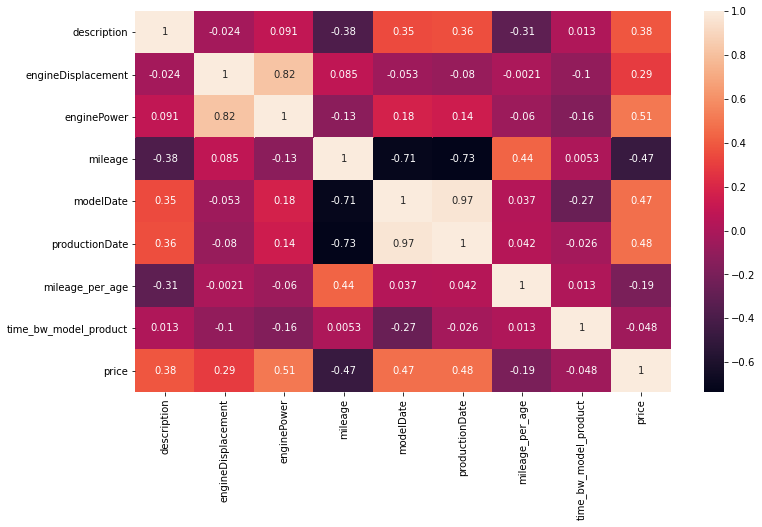

In [923]:
# Постороим матрицу корреляций числовых переменных друг с другом и с целевой переменной price.
plt.figure(figsize=(12,7))
sns.heatmap(cdf[cdf['train'] == 1][num_cols + ['price']].corr(), annot=True)

1. Самая высокая корреляция между 2 столбцов 'modelDate' (дата модели), 'productionDate' (дата выпуска) = 0.97. Оставим для обучения только один из них - 'productionDate'
2. Далее немалая корреляция по столбцам 'engineDisplacement' (объем двигателя) и 'enginePower' (мощность двигателя) = 0.82. Поэтому удаляем один признак - engineDisplacement (объем двигателя), т.к. enginePower (мощность двигателя) более скоррелирован с целевой переменной.
3. Есть значительная кореляция между 'modelDate' (дата модели)/'productionDate' (дата выпуска) и 'mileage'  (пробег автомобиля) - пока оставим оба столбца

In [924]:
cdf.drop(['modelDate', 'engineDisplacement'], axis = 1, inplace = True)
cdf

,bodyType,brand,color,description,enginePower,fuelType,mileage,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut,mileage_per_age,time_bw_model_product,top2_bodyType,rare_bodyType,top5_colors,rare_colors
0,лифтбек,skoda,синий,145,105.0,бензин,74000,octavia,2014.0,ROBOT,3,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,10571,1.0,0,0,1,0
1,лифтбек,skoda,чёрный,357,110.0,бензин,60563,octavia,2017.0,MECHANICAL,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,15140,0.0,0,0,0,0
2,лифтбек,skoda,серый,145,152.0,бензин,88000,superb,2014.0,ROBOT,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,12571,1.0,0,0,1,0
3,лифтбек,skoda,коричневый,238,110.0,бензин,95000,octavia,2014.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,13571,1.0,0,0,0,0
4,лифтбек,skoda,белый,322,152.0,бензин,58536,octavia,2012.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,6504,4.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207553,хэтчбек,honda,зелёный,0,124.0,электро,91000,fit,2011.0,AUTOMATIC,1,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,595000.0,1,1,1,1,0,1,4,9100,4.0,0,0,0,0
207554,хэтчбек,honda,синий,123,124.0,электро,125000,fit,2010.0,AUTOMATIC,1,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,609000.0,1,0,1,1,0,1,4,11363,3.0,0,0,1,0
207555,хэтчбек,honda,серый,46,124.0,электро,119000,fit,2011.0,AUTOMATIC,2,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,567000.0,1,0,1,1,0,1,4,11900,4.0,0,0,1,0
207556,седан,honda,белый,47,161.0,электро,37000,clarity,2018.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2022-01-14,1,1309000.0,1,0,1,1,0,1,4,12333,2.0,1,0,1,0


In [925]:
num_cols = [x for x in num_cols if x not in ('modelDate', 'engineDisplacement')] 
num_cols 

['description',
 'enginePower',
 'mileage',
 'productionDate',
 'mileage_per_age',
 'time_bw_model_product']

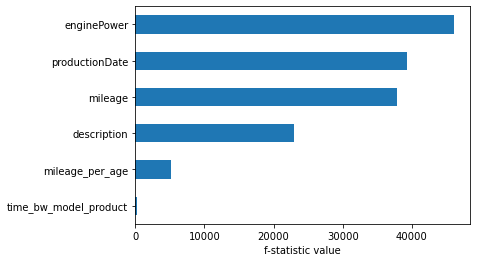

In [926]:
# Оценим значимость числовых переменных.
imp_num = pd.Series(f_regression(cdf[cdf.train == 1][num_cols], cdf[cdf.train == 1]['price'])[0],\
                    index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.xlabel('f-statistic value');

Из графика видим, что наиболее важный признак для предсказания - это enginePower (мощность двигателя), productionDate (дата выпуска), mileage (пробег)

## Обработка и анализ бинарных и категориальных признаков

In [927]:
bin_cols, cat_cols

(['description_isD', 'fuelType_isGE', 'Руль'],
 ['bodyType',
  'brand',
  'color',
  'description_cut',
  'enginePower_cut',
  'fuelType',
  'mileage_cut',
  'model_name',
  'productionDate_cut',
  'vehicleTransmission',
  'Владельцы',
  'ПТС',
  'Привод',
  'Состояние',
  'Таможня',
  'top2_bodyType',
  'rare_bodyType',
  'top5_colors',
  'rare_colors'])

In [928]:
# Сделаем копию датасета
df = cdf.copy()
# Преобразуем отобранные бинарные и категориальные признаки
label_encoder = LabelEncoder()
for column in bin_cols + cat_cols:
    df[column] = label_encoder.fit_transform(cdf[column])

In [929]:
df[bin_cols + cat_cols]

,description_isD,fuelType_isGE,Руль,bodyType,brand,color,description_cut,enginePower_cut,fuelType,mileage_cut,model_name,productionDate_cut,vehicleTransmission,Владельцы,ПТС,Привод,Состояние,Таможня,top2_bodyType,rare_bodyType,top5_colors,rare_colors
0,0,0,0,6,8,13,0,0,0,0,480,3,2,3,1,1,1,2,0,0,1,0
1,0,0,0,6,8,15,0,0,0,0,480,3,1,1,1,1,1,2,0,0,0,0
2,0,0,0,6,8,12,0,0,0,0,692,3,2,1,1,1,1,2,0,0,1,0
3,0,0,0,6,8,6,0,0,0,0,480,3,0,1,1,1,1,2,0,0,0,0
4,0,0,0,6,8,1,0,0,0,0,480,3,0,1,1,1,1,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207553,1,0,1,17,2,4,0,0,4,0,270,3,0,1,1,1,1,2,0,0,0,0
207554,0,0,1,17,2,13,0,0,4,0,270,3,0,1,1,1,1,2,0,0,1,0
207555,0,0,1,17,2,12,0,0,4,0,270,3,0,2,1,1,1,2,0,0,1,0
207556,0,0,0,11,2,1,0,0,4,0,167,3,0,1,1,1,1,2,1,0,1,0


In [930]:
for i in bin_cols:
    display(df[i].value_counts())

0    163784
1      3957
Name: description_isD, dtype: int64

0    166585
1      1156
Name: fuelType_isGE, dtype: int64

0    158161
1      9580
Name: Руль, dtype: int64

In [931]:
for i in cat_cols:
    display(df[i].value_counts())

0     65776
11    58882
17    12150
6     11051
14     5305
8      5092
3      3209
2      2614
9      1569
4       692
16      517
1       378
10      373
7        77
12       31
5        16
13        6
15        3
Name: bodyType, dtype: int64

10    23742
5     22552
9     22377
1     21306
7     20997
0     13026
8     12359
6     12116
11     5745
2      5479
4      4757
3      3285
Name: brand, dtype: int64

15    51746
1     35067
12    21033
11    19099
13    14649
6      6959
7      6561
4      3374
0      2936
2      1900
5      1110
9      1051
14      863
3       734
8       598
10       61
Name: color, dtype: int64

0    167212
1       526
3         2
2         1
Name: description_cut, dtype: int64

0    108200
1     49772
2      7590
3      2137
4        42
Name: enginePower_cut, dtype: int64

0    125682
3     37854
2      3439
4       522
1       244
Name: fuelType, dtype: int64

0    138738
1     27937
2       976
4        54
3        36
Name: mileage_cut, dtype: int64

480    5846
521    5347
131    4289
705    3688
504    3606
       ... 
501       1
446       1
577       1
451       1
552       1
Name: model_name, Length: 809, dtype: int64

3    163854
2      3817
1        68
0         2
Name: productionDate_cut, dtype: int64

0    88818
1    39647
3    20786
2    18490
Name: vehicleTransmission, dtype: int64

3    72534
1    45486
2    40108
0     9613
Name: Владельцы, dtype: int64

1    145052
0     22428
2       261
Name: ПТС, dtype: int64

2    75360
1    72982
0    19399
Name: Привод, dtype: int64

1    120287
2     47453
0         1
Name: Состояние, dtype: int64

2    120285
0     47453
1         3
Name: Таможня, dtype: int64

1    124658
0     43083
Name: top2_bodyType, dtype: int64

0    167608
1       133
Name: rare_bodyType, dtype: int64

1    89848
0    77893
Name: top5_colors, dtype: int64

0    163324
1      4417
Name: rare_colors, dtype: int64

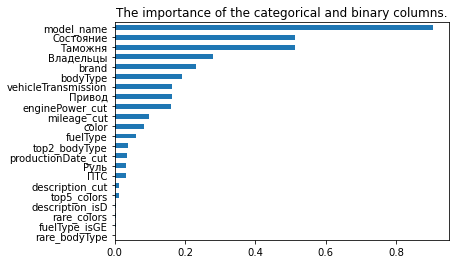

In [932]:
#imp_bin = Series(mutual_info_classif(cdf[bin_cols][cdf.train == 1], cdf[cdf.train == 1]['price'])[0], 
#                 index = bin_cols)    

#imp_bin.sort_values(inplace = True)
#imp_bin.plot(kind = 'barh')

imp_cat = pd.Series(
    mutual_info_regression(
        df[df.train == 1][list(set(df.columns) & set(cat_cols+bin_cols))], 
        df[df.train == 1]['price'], 
        discrete_features=True), index=list(set(cdf.columns) & set(cat_cols+bin_cols))
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='The importance of the categorical and binary columns.')
plt.show()

Как видно из графиков, наибольшее влияние на целевую переменную оказывают марка и модель автомобиля. Большое влияние модели автомобиля обусловлено относительно небольшим числом записей для каждой модели. Большое влияние "Владельцы" не совсем понятен, тем более врядли он изначально верно заполнялся. Возможно своим влиянием, он даже исказит предсказание.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения цены по различным параметрам неразличимы

In [933]:
"""def get_stat_dif(column):
    cols = df.loc[:, column].value_counts()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'price'], 
                        df.loc[df.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
            
for col in cat_cols + bin_cols:
    get_stat_dif(col)"""

"def get_stat_dif(column):\n    cols = df.loc[:, column].value_counts()\n    combinations_all = list(combinations(cols, 2))\n    for comb in combinations_all:\n        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'price'], \n                        df.loc[df.loc[:, column] == comb[1], 'price']).pvalue             <= 0.05/len(combinations_all): # Учли поправку Бонферони\n            print('Найдены статистически значимые различия для колонки', column)\n            break\n            \nfor col in cat_cols + bin_cols:\n    get_stat_dif(col)"

In [934]:
#df.loc[:, 'bodyType'].value_counts()
df

,bodyType,brand,color,description,enginePower,fuelType,mileage,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut,mileage_per_age,time_bw_model_product,top2_bodyType,rare_bodyType,top5_colors,rare_colors
0,6,8,13,145,105.0,0,74000,480,2014.0,2,3,1,1,0,1,2,2020-10-20,0,0.0,0,0,0,0,0,0,3,10571,1.0,0,0,1,0
1,6,8,15,357,110.0,0,60563,480,2017.0,1,1,1,1,0,1,2,2020-10-20,0,0.0,0,0,0,0,0,0,3,15140,0.0,0,0,0,0
2,6,8,12,145,152.0,0,88000,692,2014.0,2,1,1,1,0,1,2,2020-10-20,0,0.0,0,0,0,0,0,0,3,12571,1.0,0,0,1,0
3,6,8,6,238,110.0,0,95000,480,2014.0,0,1,1,1,0,1,2,2020-10-20,0,0.0,0,0,0,0,0,0,3,13571,1.0,0,0,0,0
4,6,8,1,322,152.0,0,58536,480,2012.0,0,1,1,1,0,1,2,2020-10-20,0,0.0,0,0,0,0,0,0,3,6504,4.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207553,17,2,4,0,124.0,4,91000,270,2011.0,0,1,1,1,1,1,2,2022-01-14,1,595000.0,1,1,0,0,0,0,3,9100,4.0,0,0,0,0
207554,17,2,13,123,124.0,4,125000,270,2010.0,0,1,1,1,1,1,2,2022-01-14,1,609000.0,1,0,0,0,0,0,3,11363,3.0,0,0,1,0
207555,17,2,12,46,124.0,4,119000,270,2011.0,0,2,1,1,1,1,2,2022-01-14,1,567000.0,1,0,0,0,0,0,3,11900,4.0,0,0,1,0
207556,11,2,1,47,161.0,4,37000,167,2018.0,0,1,1,1,0,1,2,2022-01-14,1,1309000.0,1,0,0,0,0,0,3,12333,2.0,1,0,1,0


# Выгрузка данных

In [935]:
# Выгрузим данные в csv для дальнейшего обучения
cdf.to_csv('C:/Users/vasil/LearningFolder1/5_module/FINALWORK/data/cdf_auto.csv', index = False)

In [936]:
# Выгрузим названия колонок по типам
df_columns = pd.DataFrame()

for col in num_cols:
    new_row = {'column_type': 'num', 'column_name': col} 
    df_columns = df_columns.append(new_row, ignore_index=True)

for col in bin_cols:
    new_row = {'column_type': 'bin', 'column_name': col} 
    df_columns = df_columns.append(new_row, ignore_index=True)

for col in cat_cols:
    new_row = {'column_type': 'cat', 'column_name': col} 
    df_columns = df_columns.append(new_row, ignore_index=True)
    
for col in add_cols:
    new_row = {'column_type': 'add', 'column_name': col} 
    df_columns = df_columns.append(new_row, ignore_index=True)
    
for col in target_cols:
    new_row = {'column_type': 'target', 'column_name': col} 
    df_columns = df_columns.append(new_row, ignore_index=True)
    
df_columns.to_csv('C:/Users/vasil/LearningFolder1/5_module/FINALWORK/data/cdf_auto_columns.csv', index = False)

In [937]:
# проверим
df_columns = pd.read_csv('C:/Users/vasil/LearningFolder1/5_module/FINALWORK/data/cdf_auto_columns.csv')
cdf[df_columns[df_columns.column_type == 'cat'].column_name.values]

,bodyType,brand,color,description_cut,enginePower_cut,fuelType,mileage_cut,model_name,productionDate_cut,vehicleTransmission,Владельцы,ПТС,Привод,Состояние,Таможня,top2_bodyType,rare_bodyType,top5_colors,rare_colors
0,лифтбек,skoda,синий,1,1,бензин,1,octavia,4,ROBOT,3,ORIGINAL,передний,GOOD,Растаможен,0,0,1,0
1,лифтбек,skoda,чёрный,1,1,бензин,1,octavia,4,MECHANICAL,1,ORIGINAL,передний,GOOD,Растаможен,0,0,0,0
2,лифтбек,skoda,серый,1,1,бензин,1,superb,4,ROBOT,1,ORIGINAL,передний,GOOD,Растаможен,0,0,1,0
3,лифтбек,skoda,коричневый,1,1,бензин,1,octavia,4,AUTOMATIC,1,ORIGINAL,передний,GOOD,Растаможен,0,0,0,0
4,лифтбек,skoda,белый,1,1,бензин,1,octavia,4,AUTOMATIC,1,ORIGINAL,передний,GOOD,Растаможен,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207553,хэтчбек,honda,зелёный,1,1,электро,1,fit,4,AUTOMATIC,1,ORIGINAL,передний,GOOD,Растаможен,0,0,0,0
207554,хэтчбек,honda,синий,1,1,электро,1,fit,4,AUTOMATIC,1,ORIGINAL,передний,GOOD,Растаможен,0,0,1,0
207555,хэтчбек,honda,серый,1,1,электро,1,fit,4,AUTOMATIC,2,ORIGINAL,передний,GOOD,Растаможен,0,0,1,0
207556,седан,honda,белый,1,1,электро,1,clarity,4,AUTOMATIC,1,ORIGINAL,передний,GOOD,Растаможен,1,0,1,0


In [938]:
cdf

,bodyType,brand,color,description,enginePower,fuelType,mileage,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut,mileage_per_age,time_bw_model_product,top2_bodyType,rare_bodyType,top5_colors,rare_colors
0,лифтбек,skoda,синий,145,105.0,бензин,74000,octavia,2014.0,ROBOT,3,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,10571,1.0,0,0,1,0
1,лифтбек,skoda,чёрный,357,110.0,бензин,60563,octavia,2017.0,MECHANICAL,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,15140,0.0,0,0,0,0
2,лифтбек,skoda,серый,145,152.0,бензин,88000,superb,2014.0,ROBOT,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,12571,1.0,0,0,1,0
3,лифтбек,skoda,коричневый,238,110.0,бензин,95000,octavia,2014.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,13571,1.0,0,0,0,0
4,лифтбек,skoda,белый,322,152.0,бензин,58536,octavia,2012.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,6504,4.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207553,хэтчбек,honda,зелёный,0,124.0,электро,91000,fit,2011.0,AUTOMATIC,1,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,595000.0,1,1,1,1,0,1,4,9100,4.0,0,0,0,0
207554,хэтчбек,honda,синий,123,124.0,электро,125000,fit,2010.0,AUTOMATIC,1,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,609000.0,1,0,1,1,0,1,4,11363,3.0,0,0,1,0
207555,хэтчбек,honda,серый,46,124.0,электро,119000,fit,2011.0,AUTOMATIC,2,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,567000.0,1,0,1,1,0,1,4,11900,4.0,0,0,1,0
207556,седан,honda,белый,47,161.0,электро,37000,clarity,2018.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2022-01-14,1,1309000.0,1,0,1,1,0,1,4,12333,2.0,1,0,1,0


In [939]:
df_columns

,column_name,column_type
0,description,num
1,enginePower,num
2,mileage,num
3,productionDate,num
4,mileage_per_age,num
...,...,...
27,rare_colors,cat
28,train,add
29,new_data,add
30,parsing_date,add


In [940]:
# проверим что ничего не забыли
set(cdf.columns).difference(df_columns.column_name.to_list())

set()

In [941]:
cdf[cdf.train ==0]

,bodyType,brand,color,description,enginePower,fuelType,mileage,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut,mileage_per_age,time_bw_model_product,top2_bodyType,rare_bodyType,top5_colors,rare_colors
0,лифтбек,skoda,синий,145,105.0,бензин,74000,octavia,2014.0,ROBOT,3,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,10571,1.0,0,0,1,0
1,лифтбек,skoda,чёрный,357,110.0,бензин,60563,octavia,2017.0,MECHANICAL,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,15140,0.0,0,0,0,0
2,лифтбек,skoda,серый,145,152.0,бензин,88000,superb,2014.0,ROBOT,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,12571,1.0,0,0,1,0
3,лифтбек,skoda,коричневый,238,110.0,бензин,95000,octavia,2014.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,13571,1.0,0,0,0,0
4,лифтбек,skoda,белый,322,152.0,бензин,58536,octavia,2012.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2020-10-20,0,0.0,0,0,1,1,0,1,4,6504,4.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,седан,bmw,коричневый,60,136.0,бензин,115000,3er,2014.0,AUTOMATIC,3,ORIGINAL,задний,LEFT,GOOD,Растаможен,2020-10-26,0,0.0,0,0,1,1,0,1,4,16428,3.0,1,0,0,0
34682,седан,bmw,чёрный,3,190.0,дизель,98000,5er,2018.0,AUTOMATIC,1,ORIGINAL,полный,LEFT,GOOD,Растаможен,2020-10-26,0,0.0,0,0,1,1,0,1,4,32666,2.0,1,0,0,0
34683,седан,bmw,серый,2,170.0,бензин,360000,5er,1997.0,AUTOMATIC,3,DUPLICATE,задний,LEFT,GOOD,Растаможен,2020-10-26,0,0.0,0,0,1,1,0,2,4,15000,2.0,1,0,1,0
34684,внедорожник,bmw,коричневый,75,184.0,дизель,90500,x1,2013.0,AUTOMATIC,2,ORIGINAL,полный,LEFT,GOOD,Растаможен,2020-10-26,0,0.0,0,0,1,1,0,1,4,11312,1.0,1,0,0,0


In [942]:
cdf[cdf.train == 1]

,bodyType,brand,color,description,enginePower,fuelType,mileage,model_name,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,parsing_date,train,price,new_data,description_isD,description_cut,enginePower_cut,fuelType_isGE,mileage_cut,productionDate_cut,mileage_per_age,time_bw_model_product,top2_bodyType,rare_bodyType,top5_colors,rare_colors
34686,седан,audi,чёрный,32,174.0,бензин,350000,100,1991.0,MECHANICAL,3,ORIGINAL,полный,LEFT,UNKNOWN,Другое,2020-09-09,1,200000.0,0,0,1,1,0,2,3,11666,1.0,1,0,0,0
34687,седан,audi,красный,21,90.0,бензин,173424,100,1986.0,MECHANICAL,3,ORIGINAL,передний,LEFT,UNKNOWN,Другое,2020-09-09,1,60000.0,0,0,1,1,0,1,3,4954,4.0,1,0,0,0
34688,универсал,audi,синий,165,136.0,бензин,230000,100,1989.0,MECHANICAL,3,ORIGINAL,полный,LEFT,UNKNOWN,Другое,2020-09-09,1,99000.0,0,0,1,1,0,1,3,7187,1.0,0,0,1,0
34689,седан,audi,серебристый,0,90.0,бензин,240000,100,1989.0,MECHANICAL,3,ORIGINAL,передний,LEFT,UNKNOWN,Другое,2020-09-09,1,65000.0,0,1,1,1,0,2,3,7500,1.0,1,0,1,0
34690,седан,audi,чёрный,34,101.0,бензин,300000,100,1991.0,MECHANICAL,3,DUPLICATE,передний,LEFT,UNKNOWN,Другое,2020-09-09,1,100000.0,0,0,1,1,0,2,3,10000,1.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207553,хэтчбек,honda,зелёный,0,124.0,электро,91000,fit,2011.0,AUTOMATIC,1,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,595000.0,1,1,1,1,0,1,4,9100,4.0,0,0,0,0
207554,хэтчбек,honda,синий,123,124.0,электро,125000,fit,2010.0,AUTOMATIC,1,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,609000.0,1,0,1,1,0,1,4,11363,3.0,0,0,1,0
207555,хэтчбек,honda,серый,46,124.0,электро,119000,fit,2011.0,AUTOMATIC,2,ORIGINAL,передний,RIGHT,GOOD,Растаможен,2022-01-14,1,567000.0,1,0,1,1,0,1,4,11900,4.0,0,0,1,0
207556,седан,honda,белый,47,161.0,электро,37000,clarity,2018.0,AUTOMATIC,1,ORIGINAL,передний,LEFT,GOOD,Растаможен,2022-01-14,1,1309000.0,1,0,1,1,0,1,4,12333,2.0,1,0,1,0


Выводы:
1. Только в конце поняла что после объединения 3 баз удаляла записи не анализируя на пренадлежность к базе TEST. По счастливой случайности записи в тестовой базе сохранились ... 34686 записей. По хорошему нужно пересмотреть код на этот счет.
2. Перейдем наконец к обучению.
